In [13]:
# --- IMPORT LIBRARIES ---
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [25]:
# --- Step 1: Load DEMs ---
ref_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Processed\DEM2022.tif'
target_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Processed\DEM2023corrected.tif'
output_dod_path = r'D:\PhD\Aerial Data Processed\PGSP\DoD\DoD_2023'
with rasterio.open(ref_path) as src_ref:
    ref = src_ref.read(1)
    ref_profile = src_ref.profile

with rasterio.open(target_path) as src_target:
    target = src_target.read(1)
    target_profile = src_target.profile


In [26]:
# --- Step 2: Handle Different Shapes (Resample Target if Needed) ---
from rasterio.enums import Resampling

if ref.shape != target.shape:
    print("Shape mismatch detected. Resampling target DEM to match reference DEM.")
    with rasterio.open(target_path) as src_target:
        target_resampled = src_target.read(
            1,
            out_shape=(src_ref.count, ref.shape[0], ref.shape[1]),
            resampling=Resampling.bilinear
        )
        transform = src_target.transform
        scale_x = src_target.width / ref.shape[1]
        scale_y = src_target.height / ref.shape[0]
        new_transform = rasterio.Affine(transform.a * scale_x, transform.b, transform.c,
                                        transform.d, transform.e * scale_y, transform.f)

        target = target_resampled
        target_profile.update({
            'height': ref.shape[0],
            'width': ref.shape[1],
            'transform': new_transform
        })
    print("Resampling completed.")


Shape mismatch detected. Resampling target DEM to match reference DEM.
Resampling completed.


In [27]:
# --- Step 3: Create Valid Data Mask ---
ref_nodata = ref_profile.get('nodata', None)
target_nodata = target_profile.get('nodata', None)

mask = (~np.isnan(ref)) & (~np.isnan(target))
if ref_nodata is not None:
    mask &= (ref != ref_nodata)
if target_nodata is not None:
    mask &= (target != target_nodata)

# Masked arrays
ref_masked = ref[mask]
target_masked = target[mask]
rows, cols = np.indices(ref.shape)
row = rows[mask]
col = cols[mask]



In [30]:
from sklearn.preprocessing import PolynomialFeatures

In [31]:
# --- Step 4: Polynomial Surface Regression to Model the Tilt ---
degree = 2  # You can try 3 if needed
poly = PolynomialFeatures(degree=degree, include_bias=False)

# Inputs
X = np.column_stack((row, col))
X_poly = poly.fit_transform(X)

# Target: elevation difference (bias between DEMs)
y = target_masked - ref_masked  # So we can model the distortion (bias)

# Fit model
model = LinearRegression()
model.fit(X_poly, y)

rows_all, cols_all = np.indices(ref.shape)


In [32]:
# --- Step 5: Predict the bias across full grid ---
X_all = np.column_stack((rows_all.ravel(), cols_all.ravel()))
X_all_poly = poly.transform(X_all)
bias_pred = model.predict(X_all_poly).reshape(ref.shape)


In [33]:
# --- Step 6: Apply correction and compute DoD ---
target_corrected = target - bias_pred
DoD = ref - target_corrected  # Or vice versa depending on definitio


In [34]:
# --- Step 7: Save DoD as GeoTIFF ---
dod_profile = ref_profile.copy()
dod_profile.update({
    'dtype': 'float32',
    'nodata': -9999.0
})

DoD_out = np.where(np.isnan(DoD), -9999.0, DoD).astype(np.float32)

with rasterio.open(output_dod_path, 'w', **dod_profile) as dst:
    dst.write(DoD_out, 1)

print(f"✅ DoD saved to: {output_dod_path}")


✅ DoD saved to: D:\PhD\Aerial Data Processed\PGSP\DoD\DoD_2023


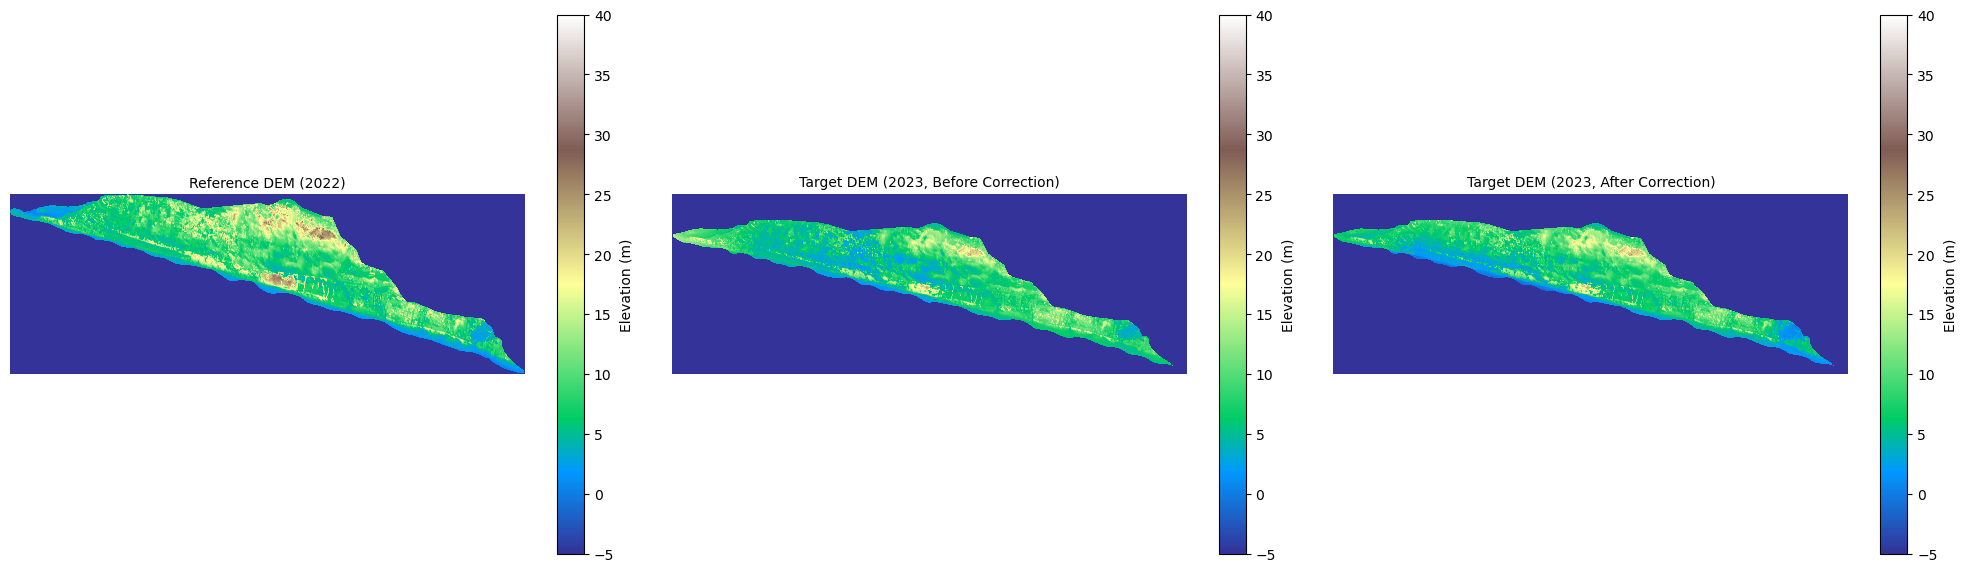

In [36]:
# --- Step 8: Visualisation ---
def plot_dem(ax, dem, title, vmin, vmax):
    cmap = plt.get_cmap('terrain')
    img = ax.imshow(dem, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    cbar = plt.colorbar(img, ax=ax, shrink=0.7)
    cbar.set_label('Elevation (m)')

elev_min = -5
elev_max = 40

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
plot_dem(axes[0], ref, 'Reference DEM (2022)', elev_min, elev_max)
plot_dem(axes[1], target, 'Target DEM (2023, Before Correction)', elev_min, elev_max)
plot_dem(axes[2], target_corrected, 'Target DEM (2023, After Correction)', elev_min, elev_max)
plt.tight_layout()
plt.show()


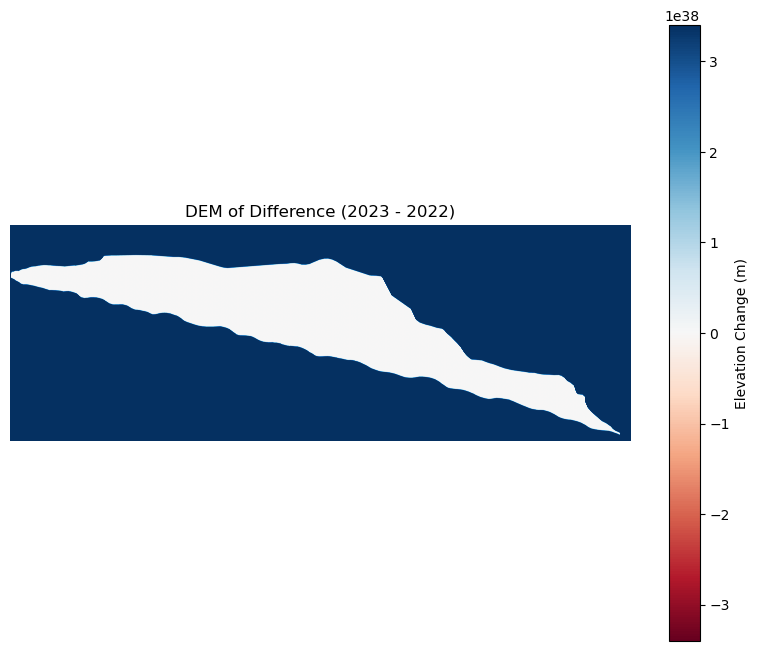

In [38]:
# Plot DoD
plt.figure(figsize=(10, 8))
cmap_diff = plt.get_cmap('RdBu')
vmax = np.nanpercentile(np.abs(DoD), 98)
plt.imshow(DoD, cmap=cmap_diff, vmin=-vmax, vmax=vmax)
plt.colorbar(label='Elevation Change (m)')
plt.title('DEM of Difference (2023 - 2022)')
plt.axis('off')
plt.show()

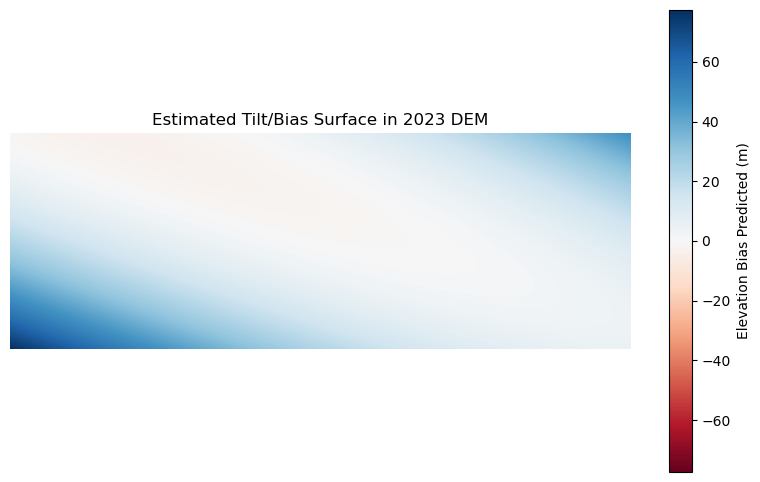

In [40]:
plt.figure(figsize=(10, 6))
plt.imshow(bias_pred, cmap='RdBu', vmin=-np.max(np.abs(bias_pred)), vmax=np.max(np.abs(bias_pred)))
plt.colorbar(label='Elevation Bias Predicted (m)')
plt.title('Estimated Tilt/Bias Surface in 2023 DEM')
plt.axis('off')
plt.show()

In [41]:
target_corrected_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Processed\DEM2023tilted.tif'

In [42]:
output_corrected_path = r'D:\PhD\Aerial Data Processed\PGSP\DEM Processed\DEM2023tilted.tif'

corrected_profile = ref_profile.copy()
corrected_profile.update({
    'dtype': 'float32',
    'nodata': -9999.0
})

target_corrected_out = np.where(np.isnan(target_corrected), -9999.0, target_corrected).astype(np.float32)

with rasterio.open(output_corrected_path, 'w', **corrected_profile) as dst:
    dst.write(target_corrected_out, 1)

print(f"✅ Corrected DEM saved to: {output_corrected_path}")



✅ Corrected DEM saved to: D:\PhD\Aerial Data Processed\PGSP\DEM Processed\DEM2023tilted.tif
